# **5. Modelo Original**

SQRE-Predictor es un enfoque de modelado en conjunto (ensemble learning) para predecir la variable RETIROS_REDENCIONES a partir de caracter√≠sticas financieras como APORTES_RECIBIDOS, PRECIERRE_FONDO_DIA_T, entre otras. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

## **5.1. Implementaci√≥n**

Para la implementaci√≥n, primero se cargan los datos desde un archivo CSV y se dividen en conjuntos de entrenamiento y prueba. Luego, se entrenan tres modelos base: XGBoost, Random Forest y K-Nearest Neighbors (KNN), cada uno con hiperpar√°metros cuidadosamente seleccionados para mejorar la generalizaci√≥n y evitar el sobreajuste. Las predicciones de estos modelos sobre los datos de entrenamiento y prueba se apilan (stacking) como entradas para un meta-modelo final: un Gradient Boosting Regressor con p√©rdida tipo cuantil (quantile), usado para robustecer las predicciones. Finalmente, se calculan m√©tricas de rendimiento como RMSE, MAE y R¬≤ para evaluar la precisi√≥n del modelo combinado tanto en entrenamiento como en prueba. Este pipeline busca aprovechar las fortalezas individuales de cada modelo base y mejorar el desempe√±o global mediante una estrategia de aprendizaje en capas.

In [ ]:

# -------------------------------
# Cargar datos
# -------------------------------
df = pd.read_csv(r'C:\Users\TAWTOCA\OneDrive - Universidad del Norte\Documentos\Visual Folders\Visual Files\Rentabilidad_filtrado.csv')

X = df[["APORTES_RECIBIDOS", "PRECIERRE_FONDO_DIA_T", "TIPO_PARTICIPACION", "NUMERO_INVERSIONISTAS", "TIPO_ENTIDAD"]]
y = df["RETIROS_REDENCIONES"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# -------------------------------
# Entrenar modelos base optimizados
# -------------------------------
print("Entrenando modelo XGBoost...")
eval_set = [(X_train, y_train), (X_test, y_test)]

model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.03, max_depth=7, early_stopping_rounds=20,
    min_child_weight=1,     # Controlar la divisi√≥n de nodos para evitar sobreajuste
    gamma=1,
    subsample=0.88,          # Tomar muestras de los datos para evitar sobreajuste
    colsample_bytree=0.8,
    reg_lambda=1,           # Regularizaci√≥n L2 (evita sobreajuste)
    tree_method='hist',     # Algoritmo optimizado para conjuntos grandes
    eval_metric="rmse",  random_state=42, n_jobs=-1)

model_xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)


print("Entrenando modelo Random Forest...")
model_rf = RandomForestRegressor(n_estimators=500, max_depth=30, min_samples_leaf= 1,
                                 min_samples_split=10, max_features='log2', bootstrap= True, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

print("Entrenando modelo KNN...")
model_knn = KNeighborsRegressor(n_neighbors=15, weights='uniform', p=2,algorithm='ball_tree', leaf_size=30, n_jobs=-1)
model_knn.fit(X_train, y_train)

# -------------------------------
# Crear predicciones para meta-modelo
# -------------------------------
pred_train_xgb = model_xgb.predict(X_train)
pred_train_rf = model_rf.predict(X_train)
pred_train_knn = model_knn.predict(X_train)

X_meta_train = np.column_stack((pred_train_xgb, pred_train_rf, pred_train_knn))

pred_test_xgb = model_xgb.predict(X_test)
pred_test_rf = model_rf.predict(X_test)
pred_test_knn = model_knn.predict(X_test)

X_meta_test = np.column_stack((pred_test_xgb, pred_test_rf, pred_test_knn))

# -------------------------------
# Meta-modelo robusto 
# -------------------------------
print("Entrenando meta-modelo GradientBoosting (quantile)...")
meta_model = GradientBoostingRegressor(loss='quantile', alpha=0.5, n_estimators=500,
                                       learning_rate=0.05, max_depth=3, subsample=0.8, random_state=42)
st = time.time()
meta_model.fit(X_meta_train, y_train)
et = time.time()
print(f"Tiempo de entrenamiento del meta-modelo: {et - st:.2f} segundos")
# -------------------------------
# Predicciones finales
# -------------------------------
y_train_pred = meta_model.predict(X_meta_train)
y_test_pred = meta_model.predict(X_meta_test)

# -------------------------------
# M√©tricas
# -------------------------------
def print_metrics(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"üîπ {label}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R¬≤:   {r2:.2f}\n")

print_metrics(y_train, y_train_pred, label="Entrenamiento")
print_metrics(y_test, y_test_pred, label="Prueba")



Entrenando modelo XGBoost...
Entrenando modelo Random Forest...
Entrenando modelo KNN...
Entrenando meta-modelo GradientBoosting (quantile)...
Tiempo de entrenamiento del meta-modelo: 374.49 segundos
üîπ Entrenamiento
  RMSE: 19623504342.83
  MAE:  3158310557.69
  R¬≤:   0.81

üîπ Prueba
  RMSE: 20241507018.19
  MAE:  5265511403.22
  R¬≤:   0.78



Los resultados obtenidos muestran un buen desempe√±o general del modelo en ambas fases. En el conjunto de entrenamiento, se observa un R¬≤ de 0.81, lo que indica que el modelo explica el 81% de la variabilidad en los datos. Las m√©tricas de error ‚ÄîRMSE de aproximadamente 19.6 mil millones y MAE de 3.15 mil millones‚Äî reflejan cierta magnitud en los errores absolutos, lo cual puede ser aceptable dependiendo de la escala de la variable objetivo (RETIROS_REDENCIONES), que parece tener valores grandes.

En el conjunto de prueba, el R¬≤ baja ligeramente a 0.78, y los errores aumentan, especialmente el MAE, que sube a m√°s de 5.2 mil millones. Este incremento sugiere que el modelo pierde algo de precisi√≥n en generalizaci√≥n, pero sin se√±ales claras de sobreajuste, ya que la ca√≠da en el rendimiento no es dr√°stica.

In [2]:
# -------------------------------
# M√©tricas individuales
# -------------------------------
def print_metrics(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"üîπ {label}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R¬≤:   {r2:.2f}\n")

print("\n=== XGBoost ===")
print_metrics(y_train, pred_train_xgb, label="Entrenamiento")
print_metrics(y_test, pred_test_xgb, label="Prueba")

print("\n=== Random Forest ===")
print_metrics(y_train, pred_train_rf, label="Entrenamiento")
print_metrics(y_test, pred_test_rf, label="Prueba")

print("\n=== KNN ===")
print_metrics(y_train, pred_train_knn, label="Entrenamiento")
print_metrics(y_test, pred_test_knn, label="Prueba")



=== XGBoost ===
üîπ Entrenamiento
  RMSE: 21049058930.67
  MAE:  6305639398.00
  R¬≤:   0.79

üîπ Prueba
  RMSE: 22084179014.20
  MAE:  6443997051.38
  R¬≤:   0.74


=== Random Forest ===
üîπ Entrenamiento
  RMSE: 14107003383.17
  MAE:  3515494264.48
  R¬≤:   0.90

üîπ Prueba
  RMSE: 20051914981.17
  MAE:  5312030138.88
  R¬≤:   0.79


=== KNN ===
üîπ Entrenamiento
  RMSE: 25629720094.02
  MAE:  6445112502.67
  R¬≤:   0.68

üîπ Prueba
  RMSE: 23199936988.02
  MAE:  6935039370.78
  R¬≤:   0.71



## **5.2. Resultados Visuales**

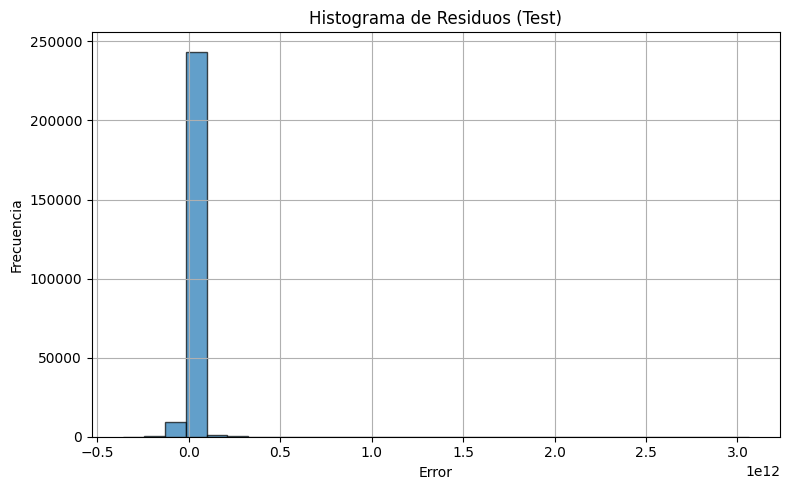

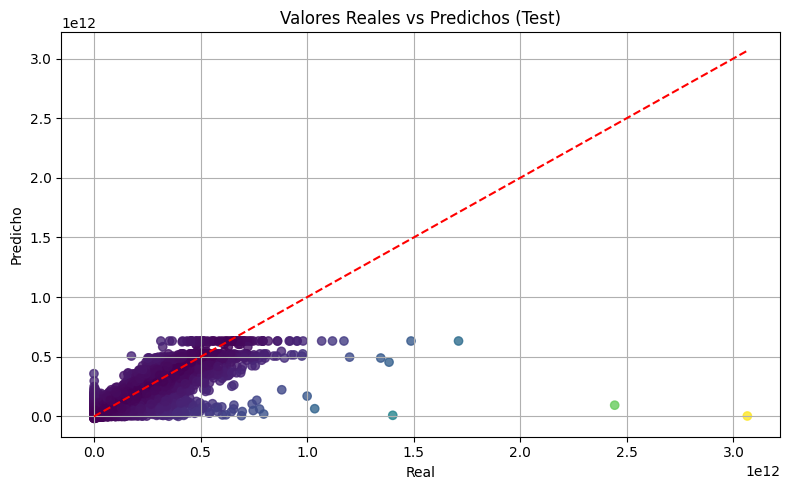

<Figure size 1000x400 with 0 Axes>

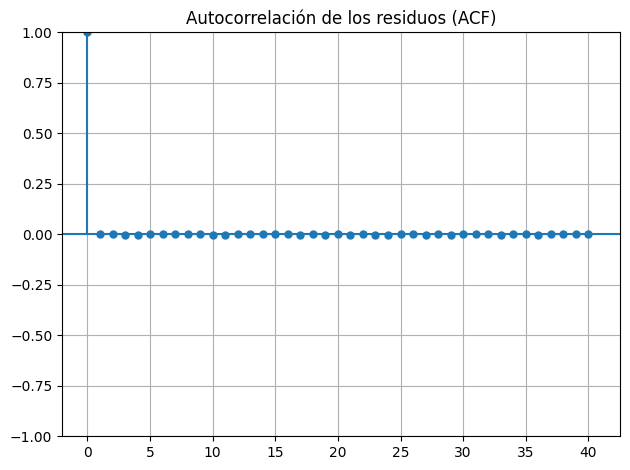

In [7]:
# -------------------------------
# Histograma de residuos
# -------------------------------
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histograma de Residuos (Test)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Gr√°fico real vs predicho
# -------------------------------
plt.figure(figsize=(8, 5))
scatter = plt.scatter(y_test, y_test_pred, c=np.abs(residuals), cmap='viridis', alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Valores Reales vs Predichos (Test)')
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------------
# Gr√°fico ACF de los residuos
# -------------------------------
plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=40, alpha=0.05)
plt.title("Autocorrelaci√≥n de los residuos (ACF)")
plt.grid(True)
plt.tight_layout()
plt.show()


üîπ **Histograma de residuos**
La mayor√≠a de los residuos est√°n fuertemente concentrados cerca de cero, lo cual es una buena se√±al de que el modelo no comete errores sistem√°ticos en la mayor√≠a de los casos. Sin embargo, se observan algunos residuos extremos (outliers) hacia la derecha del gr√°fico, lo que indica que en ciertas observaciones el modelo incurre en errores muy grandes. Esto sugiere una posible presencia de valores at√≠picos en la variable objetivo que podr√≠an estar afectando el desempe√±o.

---

üîπ **Gr√°fico de valores reales vs predichos**
La mayor√≠a de los puntos se agrupan en la parte inferior izquierda del gr√°fico, lo que indica que la mayor parte de las observaciones tienen valores reales y predichos bajos. Aunque hay una tendencia general que sigue la l√≠nea ideal (roja discontinua), se observan varios puntos alejados de esta, especialmente en valores altos de la variable real, donde el modelo tiende a **subestimar o sobreestimar considerablemente**. Esto refleja que el modelo tiene **dificultad para predecir correctamente valores extremos o muy altos**, lo que coincide con los outliers observados en el histograma.

---

üîπ **Gr√°fico ACF de los residuos**
El gr√°fico muestra que no existe autocorrelaci√≥n significativa en los residuos para los primeros 40 lags, ya que todos los valores (excepto el lag 0, que es siempre 1) est√°n dentro del intervalo de confianza. Esto es un buen indicador, ya que implica que los errores del modelo est√°n distribuidos aleatoriamente y no contienen patrones temporales o secuenciales no capturados por el modelo.



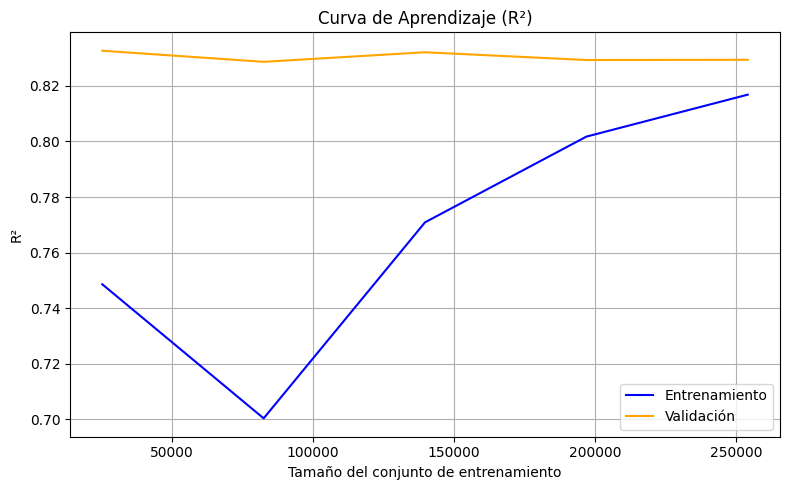

In [4]:
from sklearn.model_selection import learning_curve

# R√°pido: menos puntos, menos folds
train_sizes, train_scores, test_scores = learning_curve(
    meta_model, X_meta_train, y_train,
    cv=3,                   # menos folds
    scoring='r2',           # usamos R¬≤
    train_sizes=np.linspace(0.1, 1.0, 5),  # solo 5 puntos
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Promediar los scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label='Entrenamiento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validaci√≥n', color='orange')
plt.title('Curva de Aprendizaje (R¬≤)')
plt.xlabel('Tama√±o del conjunto de entrenamiento')
plt.ylabel('R¬≤')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


La gr√°fica muestra c√≥mo evoluciona el desempe√±o del modelo en funci√≥n del tama√±o del conjunto de entrenamiento. Se observa una brecha significativa entre las curvas de entrenamiento y validaci√≥n al inicio, lo cual es t√≠pico de modelos que a√∫n no han aprendido lo suficiente. A medida que aumenta el tama√±o del conjunto de entrenamiento, el rendimiento en entrenamiento mejora progresivamente y se acerca al desempe√±o en validaci√≥n, lo que sugiere que el modelo se beneficia de m√°s datos y est√° generalizando cada vez mejor. El hecho de que la curva de validaci√≥n se mantenga estable indica que no hay sobreajuste evidente. 

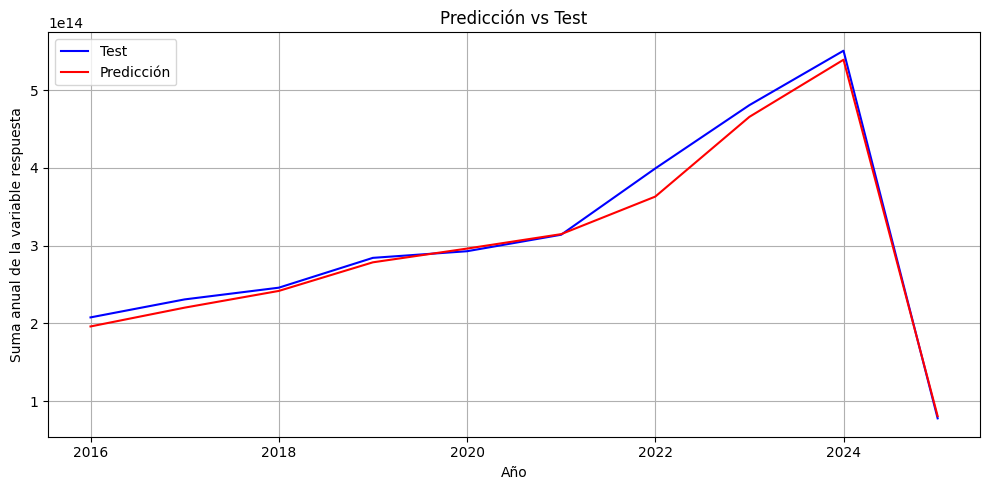

In [5]:
def predecir_y_graficar_por_anio(meta_model, X_meta_test, y_test, df_original, columna_fecha="FECHA_CORTE", titulo="Predicci√≥n vs Test"):
    """
    Genera predicciones del meta-modelo y grafica la evoluci√≥n anual (suma por a√±o) de las predicciones vs valores reales.

    Par√°metros:
    - meta_model: modelo final entrenado.
    - X_meta_test: matriz con las predicciones de los modelos base.
    - y_test: Serie con los valores reales (ya separado).
    - df_original: DataFrame original completo que contiene la columna de fecha.
    - columna_fecha: nombre de la columna con la fecha en df_original.
    - titulo: t√≠tulo del gr√°fico.
    """
    # Obtener los √≠ndices originales de X_test (para alinear fechas)
    indices_test = X_test.index

    # Extraer fechas desde el DataFrame original
    fechas_test = pd.to_datetime(df_original.loc[indices_test, columna_fecha], dayfirst=True, errors='coerce')

    # Extraer a√±o
    anios = fechas_test.dt.year

    # Predecir con meta-modelo
    y_pred = meta_model.predict(X_meta_test)

    # Crear DataFrame de resultados
    df_resultados = pd.DataFrame({
        'anio': anios.values,
        'real': y_test.values,
        'prediccion': y_pred
    })

    # Agrupar por a√±o y sumar
    suma_anual = df_resultados.groupby('anio').sum().sort_index()

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(suma_anual.index, suma_anual['real'], 'blue', label='Test')
    plt.plot(suma_anual.index, suma_anual['prediccion'], 'red', label='Predicci√≥n')
    plt.title(titulo)
    plt.xlabel("A√±o")
    plt.ylabel("Suma anual de la variable respuesta")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return suma_anual


suma_anual = predecir_y_graficar_por_anio(meta_model, X_meta_test, y_test, df)


La gr√°fica compara la suma anual de los valores reales y predichos de la variable objetivo. Se aprecia que el modelo sigue bastante bien la tendencia general del comportamiento anual, especialmente en los a√±os recientes, lo cual indica una buena capacidad de capturar patrones globales.

In [10]:
# Usamos el conjunto de test para evaluar la importancia
result = permutation_importance(
    meta_model, X_meta_test, y_test,
    n_repeats=10,        # repeticiones para robustez
    scoring='neg_mean_squared_error', 
    random_state=42, 
    n_jobs=-1
)


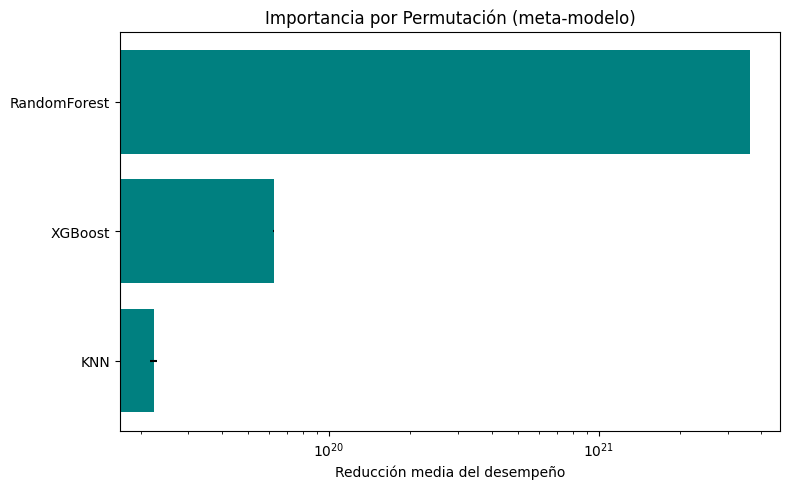

In [17]:
# Etiquetas de las variables base
feature_names = ['XGBoost', 'RandomForest', 'KNN']

# Ordenar por importancia media
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(8, 5))
plt.barh(
    range(len(sorted_idx)),
    result.importances_mean[sorted_idx],
    xerr=result.importances_std[sorted_idx],
    align='center',
    color='teal'  # Cambia el color aqu√≠
)
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title("Importancia por Permutaci√≥n (meta-modelo)")
plt.xlabel("Reducci√≥n media del desempe√±o")
plt.xscale('log')  # Si est√°s usando escala logar√≠tmica
plt.tight_layout()
plt.show()


Esta gr√°fica muestra la contribuci√≥n relativa de cada modelo base al desempe√±o del meta-modelo, medida por la reducci√≥n en el rendimiento al permutar sus predicciones. Se observa claramente que Random Forest es el componente m√°s influyente, lo que indica que sus predicciones son las m√°s √∫tiles para el meta-modelo. XGBoost tambi√©n aporta de forma significativa, aunque en menor medida, mientras que KNN tiene una importancia marginal, posiblemente porque su rendimiento individual es m√°s d√©bil o menos complementario.